# Socio-economic Factors and WFH rate

## Introduction
In this section, I used ACS data to explore nationwide WFH trend and socio-economic factors associate with it. Then, I leveraged conventional multi-OLS model and machine learning method Random Forest model to predict future WFH rate.

## Methodology
- Overview of WFH rate in the US
- Pre-select features: Based on my experience, I selected features that possibly associate with WFH rate.
- Outlier treatment and feature engineering: clean data, handle outliers and combine similar features such as occupation types.
- Feature selection: using correlation matrix to filter out features that are not highly correlate with WFH, and have high multicollinearity.
- Build, test and improve model: random forest model and multi OLS model
- Use model to predict future wfh rate

In [56]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [57]:
# load data
df = pd.read_csv('/Users/luchen/Documents/MSUA/Capstone/datasets/Census/R13392721_SL050.csv', na_values='')

print("Data shape:", df.shape)
print(df.head())

Data shape: (3221, 4096)
   Geo_FIPS                Geo_QName Geo_FILEID Geo_STUSAB  Geo_SUMLEV  \
0      1001  Autauga County, Alabama      ACSSF         al          50   
1      1003  Baldwin County, Alabama      ACSSF         al          50   
2      1005  Barbour County, Alabama      ACSSF         al          50   
3      1007     Bibb County, Alabama      ACSSF         al          50   
4      1009   Blount County, Alabama      ACSSF         al          50   

   Geo_GEOCOMP  Geo_LOGRECNO  Geo_US  Geo_REGION  Geo_DIVISION  ...  \
0            0            13     NaN         NaN           NaN  ...   
1            0            14     NaN         NaN           NaN  ...   
2            0            15     NaN         NaN           NaN  ...   
3            0            16     NaN         NaN           NaN  ...   
4            0            17     NaN         NaN           NaN  ...   

   SE_A10066_006  SE_A10066_007  SE_A10066_008  PCT_SE_A10066_002  \
0           1551            495   

## Features Used in the Model
Target feature
- % Workers 16 Years and Over: Worked At Home


- Basic demographic: 
    - ~~Population~~
    - Population Density (Per Sq. Mile)
    - ~~sex~~
    - ~~age: % Total Population: 18 to 34 Years~~ 
    - race: % White

- Household info:             
    - ~~% household with child~~
    - ~~Average Household Size~~
    - % Households income $100,000 or More
             
- Education level: % Population 25 Years and Over: Bachelor's Degree or Better
             
- Occupations Types:
This classification is based on correlation matrix analysis, and feature engineered from 12 variables to following three in the model.
    - % Workers highly likely WFH, combination of following occupations:
        - Management, Business, and Financial Operations  Occupations
        - Healthcare Support Occupations
    - % Workers very likely WFH, combination of following occupations:
        - Professional and Related Occupations
    - % Workers highly unlikely WFH, combination of following occupations:
        - Transportation and Material Moving Occupations
        - Production Occupations
    - ~~% Workers very unlikely WFH, combination of following occupations:~~
        - ~~Construction, Extraction, and Maintenance  Occupations~~
    - ~~% Workers with other type of occupations~~
             
- Housing info:             
    - ~~% house units occupied by renters~~
    - ~~Vacancy rate~~
    - ~~% housing units have 2.01 or More Occupants Per Room~~
    - ~~% renting housing units have move-in renter 2019 or later~~
    - Median House Value for All Owner-Occupied Housing Units
    - ~~Median Gross Rent as a Percentage of Household  Income in the Past 12 Months (Dollars)~~

- Commuting Means:
    - ~~Average time Commute to Work (In Min)~~
    - % Housing Units by Vehicles Available - No Vehicle Available
             
- ~~% Population Move-in within the year~~

In [58]:
# filter variables for the model
df_filtered = df[['Geo_FIPS', 'Geo_STATE', 'Geo_COUNTY', 'Geo_QName', 'Geo_STUSAB',
             
             # population
             'SE_A00001_001', 'SE_A00002_002', 
             # A00001_001:     Population
             # A00002_002:     Population Density (Per Sq. Mile)
             
             # sex
             'PCT_SE_A02001_003',
             # A02001_003:      Female
             
             # age
             'PCT_SE_B01001_003', 
             # PCT_B01001_003: % Total Population: 18 to 34 Years 
             
             # race
             'PCT_SE_A03001_002', 
             # A03001_002:      White Alone
             
             ### household type and size
             'PCT_SE_A10007A_014', 'SE_A10003_001', 
             # 'SE_A10003B_001', 
             # A10007A_014:         Child:
             # A10003_001: Average Household Size
             
             # education level
             'PCT_SE_B12001_004', #   PCT_B12001_004: % Population 25 Years and Over: Bachelor's Degree or Better
             
             # industry categories
             'SE_A17004_001', 'PCT_SE_A17004_002', 'PCT_SE_A17004_003', 'PCT_SE_A17004_004', 'PCT_SE_A17004_005', 'PCT_SE_A17004_006', 
             'PCT_SE_A17004_007', 'PCT_SE_A17004_008', 'PCT_SE_A17004_009', 'PCT_SE_A17004_010', 'PCT_SE_A17004_011', 'PCT_SE_A17004_012', 'PCT_SE_A17004_013', 'PCT_SE_A17004_014',
             # A17004_001:     Total Employed Civilian Population 16 Years and Over
                # PCT_A17004_002: % Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining
                # PCT_A17004_003: % Employed Civilian Population 16 Years and Over: Construction
                # PCT_A17004_004: % Employed Civilian Population 16 Years and Over: Manufacturing
                # PCT_A17004_005: % Employed Civilian Population 16 Years and Over: Wholesale Trade
                # PCT_A17004_006: % Employed Civilian Population 16 Years and Over: Retail Trade
                # PCT_A17004_007: % Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities
                # PCT_A17004_008: % Employed Civilian Population 16 Years and Over: Information
                # PCT_A17004_009: % Employed Civilian Population 16 Years and Over: Finance and Insurance, and Real Estate and Rental  and Leasing
                # PCT_A17004_010: % Employed Civilian Population 16 Years and Over: Professional, Scientific, and Management, and  Administrative and Waste Management Services
                # PCT_A17004_011: % Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance
                # PCT_A17004_012: % Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services
                # PCT_A17004_013: % Employed Civilian Population 16 Years and Over: Other Services, Except Public Administration
                # PCT_A17004_014: % Employed Civilian Population 16 Years and Over: Public Administration
            
             # occupations
             'PCT_SE_B17008_002', 'PCT_SE_B17008_003', 'PCT_SE_B17008_004', 'PCT_SE_B17008_005', 'PCT_SE_B17008_006', 'PCT_SE_B17008_007',
             'PCT_SE_B17008_008', 'PCT_SE_B17008_009', 'PCT_SE_B17008_010', 'PCT_SE_B17008_011', 'PCT_SE_B17008_012', 'PCT_SE_B17008_013', 'PCT_SE_B17008_014',
                # PCT_B17008_002: % Employed Civilian Population 16 Years and Over: Management, Business, and Financial Operations  Occupations
                # PCT_B17008_003: % Employed Civilian Population 16 Years and Over: Professional and Related Occupations
                # PCT_B17008_004: % Employed Civilian Population 16 Years and Over: Healthcare Support Occupations
                # PCT_B17008_005: % Employed Civilian Population 16 Years and Over: Protective Service Occupations
                # PCT_B17008_006: % Employed Civilian Population 16 Years and Over: Food Preparation and Serving Related Occupations
                # PCT_B17008_007: % Employed Civilian Population 16 Years and Over: Building and Grounds Cleaning and Maintenance  Occupations
                # PCT_B17008_008: % Employed Civilian Population 16 Years and Over: Personal Care and Service Occupations
                # PCT_B17008_009: % Employed Civilian Population 16 Years and Over: Sales and Related Occupations
                # PCT_B17008_010: % Employed Civilian Population 16 Years and Over: Office and Administrative Support Occupations
                # PCT_B17008_011: % Employed Civilian Population 16 Years and Over: Farming, Fishing, and Forestry Occupations
                # PCT_B17008_012: % Employed Civilian Population 16 Years and Over: Construction, Extraction, and Maintenance  Occupations
                # PCT_B17008_013: % Employed Civilian Population 16 Years and Over: Production Occupations
                # PCT_B17008_014: % Employed Civilian Population 16 Years and Over: Transportation and Material Moving Occupations
             
             # household income
             'SE_B14001_001', 'PCT_SE_B14001_002', 'PCT_SE_B14001_003', 'PCT_SE_B14001_004', 'PCT_SE_B14001_005', 'PCT_SE_B14001_006',
                # B14001_001:     Households   
                #   PCT_B14001_002: % Households: Less than $25,000
                #   PCT_B14001_003: % Households: $25,000 to $49,999
                #   PCT_B14001_004: % Households: $50,000 to $74,999
                #   PCT_B14001_005: % Households: $75,000 to $99,999
                #   PCT_B14001_006: % Households: $100,000 or More
             
             # renter occupied rate
             'PCT_SE_A10060_003', 
             # A10060_003:      Renter Occupied
             
             # vacancy rate
             'PCT_SE_A10044_003', 
             # A10044_003:      Vacant
             
             # Housing Units by Number of Occupants Per Room
             'PCT_SE_A10028_006', 
             # A10028_006:      2.01 or More Occupants Per Room
             
             'PCT_SE_A10063B_002',   
             # renting housing units and newly move-in renter 2019 or later
             
             # house value
             'SE_A10036_001',
             # A10036_001:     Median House Value for All Owner-Occupied Housing Units - Median Value
             
             # renting price
             'SE_A18003_001',
             # A18003_001:   Median Gross Rent as a Percentage of Household  Income in the Past 12 Months (Dollars)
    
             # WFH rate
             'PCT_SE_A09005_008',
             # A09005_001:     Workers 16 Years and Over:
             #   PCT_A09005_008: % Workers 16 Years and Over: Worked At Home
             
             # commuting time
             'SE_A09003_001',
             # A09003_001:     Average Commute to Work (In Min)
             
             # Housing Units by Vehicles Available
             'PCT_SE_A10030_002',
             # A10030_002:      No Vehicle Available
             
             # moving population rate
             'PCT_SE_A08001_002'
             # 209. Residence 1 Year Ago in the United States
               #   Universe:  Population 1 year and Over in the United States
               #   Name:      A08001
               #   Variables:
               #      A08001_001:   Total:
               #      A08001_002:      Same House 1 Year Ago
               #      A08001_003:      Moved WithIn Same County
               #      A08001_004:      Moved From Different County WithIn Same State
               #      A08001_005:      Moved From Different State
               #      A08001_006:      Moved From Abroad

             ]]

print("Data shape:", df_filtered.shape)
print(df_filtered.head())

print (df_filtered['SE_A00001_001'].min())
print (df_filtered['SE_A00001_001'].max())

Data shape: (3221, 56)
   Geo_FIPS  Geo_STATE  Geo_COUNTY                Geo_QName Geo_STUSAB  \
0      1001          1           1  Autauga County, Alabama         al   
1      1003          1           3  Baldwin County, Alabama         al   
2      1005          1           5  Barbour County, Alabama         al   
3      1007          1           7     Bibb County, Alabama         al   
4      1009          1           9   Blount County, Alabama         al   

   SE_A00001_001  SE_A00002_002  PCT_SE_A02001_003  PCT_SE_B01001_003  \
0          58239       97.97023              51.57              21.04   
1         227131      142.86440              51.23              18.08   
2          25259       28.54098              47.10              21.98   
3          22412       36.00497              45.12              22.65   
4          58884       91.30850              49.85              19.64   

   PCT_SE_A03001_002  ...  PCT_SE_A10060_003  PCT_SE_A10044_003  \
0              75.13  ... 

In [59]:
### Data Processing and Feature Engineering
### handle outliers
census = df_filtered[(df_filtered['SE_A00001_001'] >= 200)].copy()

# drop nan
census = census.dropna()

# combine occupations
census['PCT_+4_ocp'] = census['PCT_SE_B17008_002'] + census['PCT_SE_B17008_004'] 
census['PCT_+2_ocp'] = census['PCT_SE_B17008_003']
census['PCT_+1_ocp'] = census['PCT_SE_B17008_011'] + census['PCT_SE_B17008_008']
census['PCT_-1_ocp'] = census['PCT_SE_B17008_007'] + census['PCT_SE_B17008_002'] + census['PCT_SE_B17008_005'] + census['PCT_SE_B17008_004'] 
census['PCT_-2_ocp'] = census['PCT_SE_B17008_012']
census['PCT_-4_ocp'] = census['PCT_SE_B17008_014'] + census['PCT_SE_B17008_013']

# moving rate
census['moving_in'] = 1 - census['PCT_SE_A08001_002']
              
print("Data shape:", census.shape)

Data shape: (3138, 63)


In [60]:
# WFH rate per state
group_by_state = census.groupby(['Geo_STUSAB'])['PCT_SE_A09005_008'].mean().sort_values(ascending=False)
print (group_by_state)

group_by_state.to_csv('/Users/luchen/Documents/Esri/Project/results/demographic/wfh_group_by_state.csv', index=False)

## TODO ##
# map of wfh

Geo_STUSAB
dc    19.830000
mt    12.213750
co    11.651406
ma    11.331429
sd    10.826364
ca    10.798793
vt    10.617143
wa    10.295897
or     9.995278
ct     9.990000
nj     9.894286
md     9.826667
nh     9.722000
ut     9.683103
me     9.296875
id     9.052045
mn     8.952529
ri     8.772000
de     8.766667
ne     8.691075
va     8.040376
fl     7.932537
ny     7.922742
nd     7.915660
hi     7.887500
wi     7.883750
nm     7.666364
wy     7.463913
ia     7.383838
pa     7.332687
az     7.170667
ks     7.109810
ak     6.805333
mi     6.741084
nv     6.672941
mo     6.603043
nc     6.438900
il     6.331471
oh     5.966818
tn     5.749158
tx     5.696240
in     5.480326
ok     5.465714
ga     5.424465
wv     5.306727
ky     5.237750
sc     4.800217
ar     4.278133
al     3.883731
la     3.683281
ms     3.080976
Name: PCT_SE_A09005_008, dtype: float64


In [61]:
# WFH rate per county
group_by_county = census.groupby(['Geo_QName'])['PCT_SE_A09005_008'].mean().sort_values(ascending=False).head(20)
print (group_by_county)

group_by_county.to_csv('/Users/luchen/Documents/Esri/Project/results/demographic/wfh_group_by_county.csv', index=False)

## TODO ##
# map of wfh

Geo_QName
Perkins County, South Dakota     34.78
Carter County, Montana           33.74
Harding County, South Dakota     32.79
Corson County, South Dakota      32.08
Petroleum County, Montana        30.61
Garfield County, Montana         30.37
Ziebach County, South Dakota     29.69
Custer County, Idaho             28.99
Trinity County, California       27.89
Alpine County, California        27.24
Campbell County, South Dakota    25.50
Knox County, Missouri            24.17
Custer County, Colorado          23.57
Prairie County, Montana          23.24
McPherson County, Nebraska       23.17
Liberty County, Montana          22.97
Grant County, Nebraska           22.19
Wheatland County, Montana        21.98
Marin County, California         21.92
Forsyth County, Georgia          21.79
Name: PCT_SE_A09005_008, dtype: float64


PCT_SE_A09005_008    1.000000
PCT_+4_ocp           0.642634
PCT_SE_B12001_004    0.567461
SE_A10036_001        0.495644
PCT_SE_B14001_006    0.462094
PCT_+2_ocp           0.287447
SE_A00002_002        0.134161
PCT_SE_A03001_002    0.131413
PCT_SE_A10030_002   -0.123929
PCT_-4_ocp          -0.534488
Name: PCT_SE_A09005_008, dtype: float64


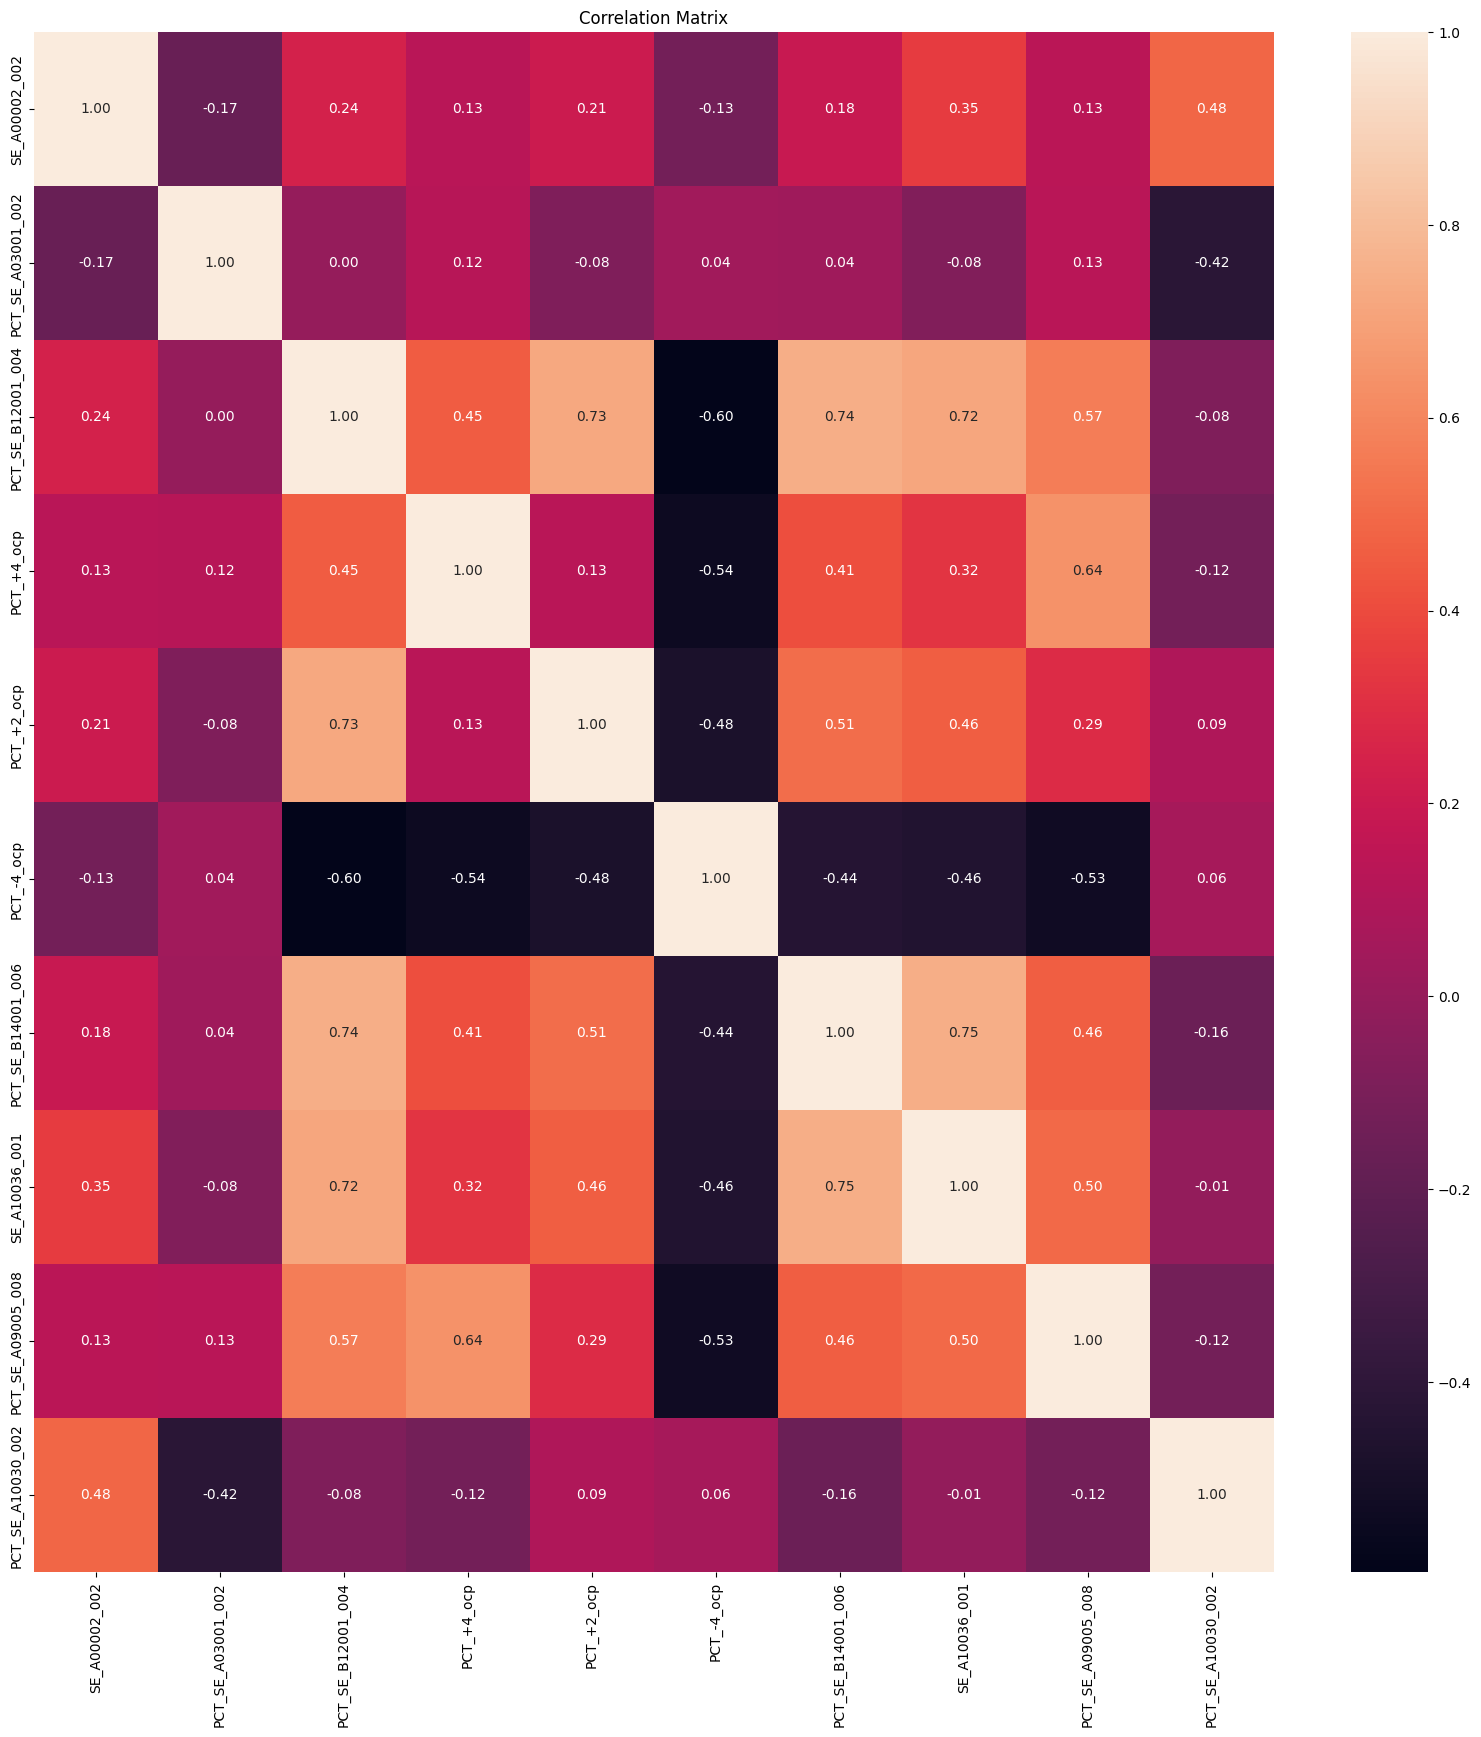

In [62]:
# correlation modeling

# STEP 2 - Selected Features

corr = census[[
             # population
             #'SE_A00001_001', 
             'SE_A00002_002', 
             # A00001_001:     Population
             # A00002_002:     Population Density (Per Sq. Mile)
             
             # sex
             #'PCT_SE_A02001_003',
             # A02001_003:      Female
             
             # age
             #'PCT_SE_B01001_003', 
             # PCT_B01001_003: % Total Population: 18 to 34 Years 
             
             # race
             'PCT_SE_A03001_002', 
             # A03001_002:      White Alone
             
             ### household type and size
             #'PCT_SE_A10007A_014', 
             #'SE_A10003_001', 
             # 'SE_A10003B_001', 
             # A10007A_014:         Child:
             # A10003_001: Average Household Size
             
             # education level
             'PCT_SE_B12001_004', #   PCT_B12001_004: % Population 25 Years and Over: Bachelor's Degree or Better
             
            #  # occupations
            #  'PCT_SE_B17008_002', 
            #  'PCT_SE_B17008_003', 
            #  'PCT_SE_B17008_004', 
            #  'PCT_SE_B17008_005', 
            #  'PCT_SE_B17008_006', 
            #  'PCT_SE_B17008_007',
            #  'PCT_SE_B17008_008', 
            #  'PCT_SE_B17008_009', 
            #  'PCT_SE_B17008_010', 
            #  'PCT_SE_B17008_011', 
            #  'PCT_SE_B17008_012', 
            #  'PCT_SE_B17008_013', 
            #  'PCT_SE_B17008_014',
            #  #'PCT_ocp_003005', # combine
            #     # PCT_B17008_002: % Employed Civilian Population 16 Years and Over: Management, Business, and Financial Operations  Occupations
            #     # PCT_B17008_003: % Employed Civilian Population 16 Years and Over: Professional and Related Occupations
            #     # PCT_B17008_004: % Employed Civilian Population 16 Years and Over: Healthcare Support Occupations
            #     # PCT_B17008_005: % Employed Civilian Population 16 Years and Over: Protective Service Occupations
            #     # PCT_B17008_006: % Employed Civilian Population 16 Years and Over: Food Preparation and Serving Related Occupations
            #     # PCT_B17008_007: % Employed Civilian Population 16 Years and Over: Building and Grounds Cleaning and Maintenance  Occupations
            #     # PCT_B17008_008: % Employed Civilian Population 16 Years and Over: Personal Care and Service Occupations
            #     # PCT_B17008_009: % Employed Civilian Population 16 Years and Over: Sales and Related Occupations
            #     # PCT_B17008_010: % Employed Civilian Population 16 Years and Over: Office and Administrative Support Occupations
            #     # PCT_B17008_011: % Employed Civilian Population 16 Years and Over: Farming, Fishing, and Forestry Occupations
            #     # PCT_B17008_012: % Employed Civilian Population 16 Years and Over: Construction, Extraction, and Maintenance  Occupations
            #     # PCT_B17008_013: % Employed Civilian Population 16 Years and Over: Production Occupations
            #     # PCT_B17008_014: % Employed Civilian Population 16 Years and Over: Transportation and Material Moving Occupations

            'PCT_+4_ocp', 
            'PCT_+2_ocp', 
            # 'PCT_+1_ocp', 
            # 'PCT_-1_ocp', 
            #'PCT_-2_ocp', 
            'PCT_-4_ocp',
            
             # household income
             'PCT_SE_B14001_006',
                #   PCT_B14001_006: % Households: $100,000 or More
             
             # renter occupied rate
             #'PCT_SE_A10060_003', 
             # A10060_003:      Renter Occupied
             
             # vacancy rate
             #'PCT_SE_A10044_003', 
             # A10044_003:      Vacant
             
             # Housing Units by Number of Occupants Per Room
             #'PCT_SE_A10028_006', 
             # A10028_006:      2.01 or More Occupants Per Room
             
             #'PCT_SE_A10063B_002',   
             # renting housing units and newly move-in renter 2019 or later
             
             # house value
             'SE_A10036_001',
             # A10036_001:     Median House Value for All Owner-Occupied Housing Units - Median Value
             
             # renting price
             #'SE_A18003_001',
             # A18003_001:   Median Gross Rent as a Percentage of Household  Income in the Past 12 Months (Dollars)
    
             # WFH rate
             'PCT_SE_A09005_008',
             # A09005_001:     Workers 16 Years and Over:
             #   PCT_A09005_008: % Workers 16 Years and Over: Worked At Home
             
             # commuting time
             #'SE_A09003_001',
             # A09003_001:     Average Commute to Work (In Min)
             
            #'PCT_likely_ocp', 'PCT_unlikely_ocp',
            
             # Housing Units by Vehicles Available
             'PCT_SE_A10030_002',
             # A10030_002:      No Vehicle Available
             
             # moving population rate
             #'moving_in'
             #'PCT_SE_A08001_002'
             # 209. Residence 1 Year Ago in the United States
               #   Universe:  Population 1 year and Over in the United States
               #   Name:      A08001
               #   Variables:
               #      A08001_001:   Total:
               #      A08001_002:      Same House 1 Year Ago
               #      A08001_003:      Moved WithIn Same County
               #      A08001_004:      Moved From Different County WithIn Same State
               #      A08001_005:      Moved From Different State
               #      A08001_006:      Moved From Abroad

             ]]

# create a correlation matrix
corr_matrix = corr.corr()
print(corr_matrix['PCT_SE_A09005_008'].sort_values(ascending=False))


# plot a heatmap to visualize the correlations
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

corr_matrix = corr_matrix['PCT_SE_A09005_008']


In [63]:
## Clean up df
corr_viz = census[[
             # population
             #'SE_A00001_001', 
             'SE_A00002_002', 
             # A00001_001:     Population
             # A00002_002:     Population Density (Per Sq. Mile)
             
             # race
             'PCT_SE_A03001_002', 
             # A03001_002:      White Alone
             
             # education level
             'PCT_SE_B12001_004', #   PCT_B12001_004: % Population 25 Years and Over: Bachelor's Degree or Better

            'PCT_+4_ocp', 
            'PCT_+2_ocp', 
            # 'PCT_+1_ocp', 
            # 'PCT_-1_ocp', 
            #'PCT_-2_ocp', 
            'PCT_-4_ocp',
            
             # household income
             'PCT_SE_B14001_006',
                #   PCT_B14001_006: % Households: $100,000 or More
             
             # house value
             'SE_A10036_001',
             # A10036_001:     Median House Value for All Owner-Occupied Housing Units - Median Value

             # WFH rate
             'PCT_SE_A09005_008',
             # A09005_001:     Workers 16 Years and Over:
             #   PCT_A09005_008: % Workers 16 Years and Over: Worked At Home
            
             # Housing Units by Vehicles Available
             'PCT_SE_A10030_002',
             # A10030_002:      No Vehicle Available

             ]].copy()

column_name_map = {
                    'SE_A00002_002': 'Population Density',
                    'PCT_SE_A03001_002': '% White population',
                    'PCT_SE_B12001_004': ' % Bachelor or higher',
                    'PCT_+4_ocp': '% Occupations - Highly likely WFH',
                    'PCT_+2_ocp': '% Occupations - Very likely WFH',
                    'PCT_-4_ocp': '% Occupations - Highly unlikely WFH',
                    'PCT_SE_B14001_006': '% Households income $100,000 or More',
                    'SE_A10036_001': 'Median House Value',
                    'PCT_SE_A10030_002': '% No Vehicle household',
                    'PCT_SE_A09005_008': 'WFH rate'
                    }

# Rename the columns using the dictionary
corr_viz.rename(columns=column_name_map, inplace=True)

corr_viz.to_csv('/Users/luchen/Documents/Esri/Project/results/demographic/modeling_wfh.csv', index=False)


In [64]:
# We'll use linear regression to try to predict 'PCT_SE_A09005_008'
# First, drop the non-numerical columns
numerical_df = corr.select_dtypes(include=[np.number])
numerical_df = numerical_df.dropna(axis=1)  # drop any columns with missing data

# prepare the data for the model
X = numerical_df.drop(['PCT_SE_A09005_008'], axis=1)  # feature columns
y = numerical_df['PCT_SE_A09005_008']  # target column

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# print model accuracy
print("Model Accuracy: ", model.score(X_test, y_test))

# print root mean squared error of the model
print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Model Accuracy:  0.5293408342456887
Root Mean Squared Error:  2.6883975817887364


In [68]:
#### correlations with 'PCT_SE_A09005_008' > 0.1
# Use boolean indexing to filter out rows with absolute correlation less than threshold
corr_matrix_01 = corr_matrix[corr_matrix.abs() > 0.1].dropna()

# Now 'filtered_corr_matrix' is your filtered correlation matrix
print(corr_matrix_01.sort_values(ascending=False))

# PCT_SE_A09005_008     1.000000 
# PCT_SE_B17008_002     0.670137 job - Management, Business, and Financial Operations  Occupations
# PCT_SE_B12001_004     0.570593 bachelor and higher education
# SE_A10036_001         0.522578 house Median Value
# PCT_SE_B14001_006     0.496803 Households income: $100,000 or More
# PCT_SE_B17008_003     0.310810 job - Professional and Related Occupations
# SE_A00001_001         0.209459 Total Population
#### PCT_SE_A10028_002     0.157873 Occupied Housing Units: 0.50 or Less Occupants Per Room
# PCT_SE_A03001_002     0.148828 White Alone rate
# SE_A00002_002         0.130798 Population Density (Per Sq. Mile)
# PCT_SE_B17008_008     0.122832 job - Personal Care and Service Occupations
# SE_A10003_001        -0.102801 Average Household Size
# PCT_SE_B17008_004    -0.132468 job - Healthcare Support Occupations
# PCT_SE_B17008_007    -0.133276 job - Building and Grounds Cleaning and Maintenance  Occupations
# PCT_SE_A10030_002    -0.141094 Occupied Housing Units: No Vehicle Available
# PCT_SE_A10007A_014   -0.154723 Child
# PCT_SE_B17008_005    -0.171769 job - Protective Service Occupations
# PCT_SE_B17008_012    -0.230769 job - Construction, Extraction, and Maintenance  Occupations
# PCT_SE_B17008_014    -0.415333 job - Transportation and Material Moving Occupations
# PCT_SE_B17008_013    -0.437578 job - Production Occupations

# filter origional df, only keep above variables
cols_to_keep = corr_matrix_01.index.str.split().str[0]
corr_01 = corr[cols_to_keep]

column_name_map = {
                    'SE_A00002_002': 'Population Density',
                    'PCT_SE_A03001_002': '% White population',
                    'PCT_SE_B12001_004': ' % Bachelor or higher',
                    'PCT_+4_ocp': '% Occupations - Highly likely WFH',
                    'PCT_+2_ocp': '% Occupations - Very likely WFH',
                    'PCT_-4_ocp': '% Occupations - Highly unlikely WFH',
                    'PCT_SE_B14001_006': '% Households income $100,000 or More',
                    'SE_A10036_001': 'Median House Value',
                    'PCT_SE_A10030_002': '% No Vehicle household',
                    'PCT_SE_A09005_008': 'WFH rate'
                    }

# Rename the columns using the dictionary
corr_01 .rename(columns=column_name_map, inplace=True)

corr_01.head()

PCT_SE_A09005_008    1.000000
PCT_+4_ocp           0.642634
PCT_SE_B12001_004    0.567461
SE_A10036_001        0.495644
PCT_SE_B14001_006    0.462094
PCT_+2_ocp           0.287447
SE_A00002_002        0.134161
PCT_SE_A03001_002    0.131413
PCT_SE_A10030_002   -0.123929
PCT_-4_ocp          -0.534488
Name: PCT_SE_A09005_008, dtype: float64


,Population Density,% White population,% Bachelor or higher,% Occupations - Highly likely WFH,% Occupations - Very likely WFH,% Occupations - Highly unlikely WFH,"% Households income $100,000 or More",Median House Value,WFH rate,% No Vehicle household
0,97.97023,75.13,28.13,18.07,22.16,15.49,26.90,164900.0,4.74,5.41
1,142.86440,84.55,32.45,16.72,21.19,12.96,29.41,226600.0,7.81,2.44
2,28.54098,45.51,11.15,12.69,16.60,21.64,14.50,89500.0,1.62,11.19
3,36.00497,75.94,11.91,11.02,14.12,23.13,17.89,102900.0,4.60,6.33
4,91.30850,92.45,14.90,12.52,18.68,21.09,23.63,138100.0,2.83,4.52


In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set 
X = corr_01  # fill this with the names of your features

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data.sort_values(by='VIF'))

### New variables
#                feature         VIF
# 0        SE_A00001_001    1.479032
# 1        SE_A00002_002    1.756214
# 9    PCT_SE_B17008_005    4.463159
# 19   PCT_SE_A10030_002    5.623752
# 11   PCT_SE_B17008_008    6.981120
# 8    PCT_SE_B17008_004    7.251015
# 13   PCT_SE_B17008_013    9.312683
# 18   PCT_SE_A09005_008    9.433707
# 10   PCT_SE_B17008_007   10.261999
# 17       SE_A10036_001   13.065851
# 14   PCT_SE_B17008_014   18.448536
# 12   PCT_SE_B17008_012   18.750001
# 15   PCT_SE_B14001_006   25.406699
# 6    PCT_SE_B17008_002   35.256899
# 2    PCT_SE_A03001_002   37.401615 white
# 5    PCT_SE_B12001_004   37.854384 Bachelor's Degree or Better
# 7    PCT_SE_B17008_003   55.569799 Professional and Related Occupations
# 3   PCT_SE_A10007A_014  121.987911 child
#### x 16   PCT_SE_A10028_002  166.248418 0.50 or Less Occupants Per Room
# 4        SE_A10003_001  245.544362 Average Household Size   

                                feature        VIF
0                    Population Density   1.554886
9                % No Vehicle household   4.632037
8                              WFH rate   9.180945
5   % Occupations - Highly unlikely WFH  10.496346
7                    Median House Value  10.865256
6  % Households income $100,000 or More  23.750682
1                    % White population  24.821673
3     % Occupations - Highly likely WFH  25.545093
2                  % Bachelor or higher  31.617824
4       % Occupations - Very likely WFH  35.162465


In [72]:
# # # We'll use linear regression to try to predict 'PCT_SE_A09005_008'
# # First, drop the non-numerical columns
# numerical_df = corr_01.select_dtypes(include=[np.number])
# numerical_df = numerical_df.dropna(axis=1)  # drop any columns with missing data

# # prepare the data for the model
# X = numerical_df.drop(['WFH rate'], axis=1)  # feature columns
# y = numerical_df['WFH rate']  # target column

# # split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # train the model
# model = LinearRegression()
# model.fit(X_train, y_train)

# # make predictions on the test set
# y_pred = model.predict(X_test)

# # print model accuracy
# print("R_sqr: ", model.score(X_test, y_test))

# # print root mean squared error of the model
# print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# # Model Accuracy:  0.5447290108359033
# # Root Mean Squared Error:  2.510557765700817

# ### 0.1
# # Model Accuracy:  0.5642617743409818
# # Root Mean Squared Error:  2.4561113969779975

# ### new variable with all occupations
# # Model Accuracy:  0.54552781805636
# # Root Mean Squared Error:  2.641763214035176

In [73]:
# Random Forest Prediction

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets[[']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Use the model to predict the test set results
y_pred = rf.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate Model Accuracy
r_sqr = rf.score(X_test, y_test)

print(f'R square: {r_sqr}')
print(f'Root Mean Squared Error: {rmse}')

# Model Accuracy: 0.5629331712186789
# Root Mean Squared Error: 2.4598529939068827

### 0.1
# Model Accuracy: 0.5704371756265633
# Root Mean Squared Error: 2.438644950165364

### new variable with all occupations
# Model Accuracy: 0.5891962418595987
# Root Mean Squared Error: 2.511640282113597

R square: 0.5834590688657151
Root Mean Squared Error: 2.5291179125547103


In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# # Initialize the model
# rf = RandomForestRegressor(random_state=42)

# # Initialize the grid search model
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_

# # Train and predict using the model with the best parameters
# rf_best = RandomForestRegressor(**best_params, random_state=42)
# rf_best.fit(X_train, y_train)
# y_pred = rf_best.predict(X_test)

# # Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# # Calculate Model Accuracy
# r_sqr = rf_best.score(X_test, y_test)

# print(f'Best Parameters: {best_params}')
# print(f'R square: {r_sqr}')
# print(f'Root Mean Squared Error: {rmse}')

# Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
# R square: 0.5957757738307609
# Root Mean Squared Error: 2.491445576945272


In [74]:
### Best Random Forest

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model with the best parameters
rf = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_depth=None, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Use the model to predict the test set results
y_pred = rf.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate Model Accuracy
r_sqr = rf.score(X_test, y_test)

print(f'R square: {r_sqr}')
print(f'Root Mean Squared Error: {rmse}')

R square: 0.5854224117522504
Root Mean Squared Error: 2.523150442967705


In [75]:
## Multi-OLS

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# predictor variables are stored in X and your target variable in y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant to the independent value
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Conduct the multiple linear regression
model = sm.OLS(y_train, X_train).fit()

# Print the summary statistics of the regression model
print(model.summary())

# Predict the test set results
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R-squared
r_sqr = model.rsquared

print(f'R square: {r_sqr}')
print(f'Root Mean Squared Error: {rmse}')


                            OLS Regression Results                            
Dep. Variable:               WFH rate   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     341.2
Date:                Wed, 05 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:48:55   Log-Likelihood:                -5995.7
No. Observations:                2510   AIC:                         1.201e+04
Df Residuals:                    2500   BIC:                         1.207e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [76]:
# ### HOW TO USE THE RANDOM FOREST MODEL
# # Assuming that 'future_data' is your new data for which you want to predict WFH rates.
# # 'future_data' should be a DataFrame that includes all the necessary features 
# # and is preprocessed in the same way as your training and test data.

# # Make sure that the new data has the same features as the data the model was trained on.
# assert set(future_data.columns) == set(X.columns), "Features do not match!"

# future_predictions = rf.predict(future_data)

# # Now, 'future_predictions' contains the predicted WFH rates for your future data.
# print(future_predictions)